## Importing all the necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense,Flatten,Dropout,LSTM
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import os
#print(os.listdir("../input"))

Using TensorFlow backend.


In [19]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [0]:
import pickle
import gzip
import _pickle
with gzip.open('/content/gdrive/My Drive/amazon_food_reviews.pkl', 'rb') as handle:
    data = _pickle.load(handle)

In [0]:
#amazon_data = pd.read_csv("Reviews.csv")
#df = amazon_data.copy()

In [0]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Cleaning and Deduplication

In [0]:
df = df[df['Score']!=3]

In [0]:
def polarity(data):
    if data >3:
        return(1)
    else:
        return(0)
df['Score'] = list(df['Score'].apply(polarity))

In [0]:
sorted_data = df.sort_values('ProductId',axis=0,kind = 'quicksort',ascending = True,na_position='last')
df = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [0]:
df = df[df.HelpfulnessNumerator<=df.HelpfulnessDenominator]

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

 67%|████████████████████████████████████████████████▏                       | 243452/364171 [01:37<00:52, 2278.06it/s]

In [0]:
df['Text'] = preprocessed_reviews

## Considering First 50k datapoints 

In [22]:
df_50k = data[:50000][['Text','Score']]
df_50k.head()

,Text,Score
150523,witty little book makes son laugh loud recite ...,1
150505,grew reading sendak books watching really rosi...,1
150506,fun way children learn months year learn poems...,1
150507,great little book read aloud nice rhythm well ...,1
150508,book poetry months year goes month cute little...,1


In [0]:
from sklearn.model_selection import train_test_split
y = df_50k['Score'].values
X = df_50k.drop(['Score'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [0]:
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
tk = Tokenizer(num_words=5000)
tk.fit_on_texts(list(X_train['Text'].values))
X_train = tk.texts_to_sequences(list(X_train['Text'].values))
X_test = tk.texts_to_sequences(list(X_test['Text'].values))

In [0]:
max_seq = 500
X_train = sequence.pad_sequences(X_train,maxlen=max_seq)
X_test = sequence.pad_sequences(X_test,maxlen = max_seq)

##  LSTM MODEL WITH 1 LAYER

In [0]:
from keras.layers import BatchNormalization,Activation
from keras.regularizers import L1L2
reg = L1L2(0.01,0.01)
embed_layer = 32
model_lstm_1 = Sequential()
model_lstm_1.add(Embedding(5000,embed_layer,input_length=max_seq))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(0.3))
model_lstm_1.add(LSTM(100,bias_regularizer=reg))
model_lstm_1.add(Dropout(0.3))
model_lstm_1.add(Dense(1,activation='sigmoid'))
model_lstm_1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,429
Trainable params: 213,365
Non-trainable params: 64
_________________________________________________________________


In [0]:
model_lstm_1.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
result = model_lstm_1.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.2)
score = model_lstm_1.evaluate(X_test,y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 28000 samples, validate on 7000 samples
Epoch 1/5


12992/28000 [============>.................] - ETA: 20:47 - loss: 2.7256 - acc: 0.40 - ETA: 13:53 - loss: 2.6636 - acc: 0.60 - ETA: 11:33 - loss: 2.6119 - acc: 0.69 - ETA: 10:18 - loss: 2.5725 - acc: 0.73 - ETA: 9:34 - loss: 2.5366 - acc: 0.7594 - ETA: 9:09 - loss: 2.4974 - acc: 0.783 - ETA: 8:50 - loss: 2.4800 - acc: 0.794 - ETA: 8:35 - loss: 2.4667 - acc: 0.804 - ETA: 8:20 - loss: 2.4616 - acc: 0.809 - ETA: 8:08 - loss: 2.4616 - acc: 0.812 - ETA: 7:59 - loss: 2.4464 - acc: 0.821 - ETA: 7:49 - loss: 2.4472 - acc: 0.822 - ETA: 7:42 - loss: 2.4451 - acc: 0.824 - ETA: 7:35 - loss: 2.4348 - acc: 0.829 - ETA: 7:29 - loss: 2.4272 - acc: 0.833 - ETA: 7:24 - loss: 2.4257 - acc: 0.834 - ETA: 7:19 - loss: 2.4211 - acc: 0.835 - ETA: 7:16 - loss: 2.4085 - acc: 0.841 - ETA: 7:16 - loss: 2.4012 - acc: 0.843 - ETA: 7:19 - loss: 2.3990 - acc: 0.844 - ETA: 7:17 - loss: 2.3976 - acc: 0.844 - ETA: 7:15 - loss: 2.3938 - acc: 0.845 - ETA: 7:19 - loss: 2.3990 - acc: 0.842 - ETA: 7:17 - loss: 2.3965 - acc: 

28000/28000 [==============================] - ETA: 27s - loss: 1.7555 - acc: 0.88 - ETA: 26s - loss: 1.7540 - acc: 0.88 - ETA: 25s - loss: 1.7524 - acc: 0.88 - ETA: 24s - loss: 1.7508 - acc: 0.88 - ETA: 23s - loss: 1.7495 - acc: 0.88 - ETA: 22s - loss: 1.7481 - acc: 0.88 - ETA: 21s - loss: 1.7468 - acc: 0.88 - ETA: 20s - loss: 1.7453 - acc: 0.88 - ETA: 19s - loss: 1.7436 - acc: 0.88 - ETA: 18s - loss: 1.7421 - acc: 0.88 - ETA: 17s - loss: 1.7410 - acc: 0.88 - ETA: 16s - loss: 1.7400 - acc: 0.88 - ETA: 15s - loss: 1.7386 - acc: 0.88 - ETA: 14s - loss: 1.7375 - acc: 0.88 - ETA: 13s - loss: 1.7363 - acc: 0.88 - ETA: 12s - loss: 1.7348 - acc: 0.88 - ETA: 11s - loss: 1.7336 - acc: 0.88 - ETA: 10s - loss: 1.7324 - acc: 0.88 - ETA: 9s - loss: 1.7313 - acc: 0.8846 - ETA: 8s - loss: 1.7301 - acc: 0.884 - ETA: 7s - loss: 1.7288 - acc: 0.884 - ETA: 6s - loss: 1.7276 - acc: 0.884 - ETA: 5s - loss: 1.7264 - acc: 0.884 - ETA: 4s - loss: 1.7254 - acc: 0.884 - ETA: 3s - loss: 1.7243 - acc: 0.884 - ET

13056/28000 [============>.................] - ETA: 6:51 - loss: 1.1345 - acc: 0.921 - ETA: 6:35 - loss: 1.1345 - acc: 0.914 - ETA: 6:47 - loss: 1.1278 - acc: 0.921 - ETA: 6:44 - loss: 1.1233 - acc: 0.929 - ETA: 6:42 - loss: 1.1113 - acc: 0.937 - ETA: 6:38 - loss: 1.1105 - acc: 0.942 - ETA: 6:35 - loss: 1.1021 - acc: 0.944 - ETA: 6:37 - loss: 1.1048 - acc: 0.937 - ETA: 6:37 - loss: 1.1048 - acc: 0.934 - ETA: 6:36 - loss: 1.1016 - acc: 0.935 - ETA: 6:33 - loss: 1.1017 - acc: 0.937 - ETA: 6:31 - loss: 1.1027 - acc: 0.936 - ETA: 6:30 - loss: 1.1019 - acc: 0.937 - ETA: 6:30 - loss: 1.1028 - acc: 0.936 - ETA: 6:31 - loss: 1.0969 - acc: 0.937 - ETA: 6:29 - loss: 1.1112 - acc: 0.934 - ETA: 6:28 - loss: 1.1088 - acc: 0.934 - ETA: 6:30 - loss: 1.1148 - acc: 0.932 - ETA: 6:28 - loss: 1.1096 - acc: 0.933 - ETA: 6:28 - loss: 1.1112 - acc: 0.932 - ETA: 6:26 - loss: 1.1101 - acc: 0.930 - ETA: 6:26 - loss: 1.1098 - acc: 0.931 - ETA: 6:24 - loss: 1.1110 - acc: 0.930 - ETA: 6:25 - loss: 1.1058 - acc: 0

28000/28000 [==============================] - ETA: 24s - loss: 0.7951 - acc: 0.93 - ETA: 23s - loss: 0.7945 - acc: 0.93 - ETA: 23s - loss: 0.7937 - acc: 0.93 - ETA: 22s - loss: 0.7933 - acc: 0.93 - ETA: 21s - loss: 0.7927 - acc: 0.93 - ETA: 20s - loss: 0.7922 - acc: 0.93 - ETA: 19s - loss: 0.7917 - acc: 0.93 - ETA: 18s - loss: 0.7910 - acc: 0.93 - ETA: 17s - loss: 0.7905 - acc: 0.93 - ETA: 16s - loss: 0.7898 - acc: 0.93 - ETA: 15s - loss: 0.7889 - acc: 0.93 - ETA: 14s - loss: 0.7883 - acc: 0.93 - ETA: 13s - loss: 0.7877 - acc: 0.93 - ETA: 12s - loss: 0.7870 - acc: 0.93 - ETA: 11s - loss: 0.7863 - acc: 0.93 - ETA: 10s - loss: 0.7855 - acc: 0.93 - ETA: 9s - loss: 0.7851 - acc: 0.9325 - ETA: 8s - loss: 0.7843 - acc: 0.932 - ETA: 8s - loss: 0.7839 - acc: 0.932 - ETA: 7s - loss: 0.7832 - acc: 0.932 - ETA: 6s - loss: 0.7828 - acc: 0.932 - ETA: 5s - loss: 0.7824 - acc: 0.932 - ETA: 4s - loss: 0.7816 - acc: 0.932 - ETA: 3s - loss: 0.7812 - acc: 0.932 - ETA: 2s - loss: 0.7805 - acc: 0.932 - ET

13056/28000 [============>.................] - ETA: 7:27 - loss: 0.4860 - acc: 0.968 - ETA: 7:03 - loss: 0.4615 - acc: 0.968 - ETA: 7:15 - loss: 0.4408 - acc: 0.974 - ETA: 7:09 - loss: 0.4384 - acc: 0.968 - ETA: 7:09 - loss: 0.4356 - acc: 0.968 - ETA: 7:03 - loss: 0.4474 - acc: 0.960 - ETA: 7:01 - loss: 0.4415 - acc: 0.959 - ETA: 6:59 - loss: 0.4576 - acc: 0.955 - ETA: 7:04 - loss: 0.4482 - acc: 0.958 - ETA: 7:00 - loss: 0.4425 - acc: 0.957 - ETA: 6:58 - loss: 0.4434 - acc: 0.957 - ETA: 6:55 - loss: 0.4419 - acc: 0.953 - ETA: 6:53 - loss: 0.4537 - acc: 0.948 - ETA: 6:54 - loss: 0.4481 - acc: 0.950 - ETA: 6:52 - loss: 0.4481 - acc: 0.951 - ETA: 6:49 - loss: 0.4483 - acc: 0.952 - ETA: 6:49 - loss: 0.4420 - acc: 0.954 - ETA: 6:49 - loss: 0.4384 - acc: 0.954 - ETA: 6:47 - loss: 0.4359 - acc: 0.954 - ETA: 6:45 - loss: 0.4392 - acc: 0.954 - ETA: 6:44 - loss: 0.4378 - acc: 0.955 - ETA: 6:43 - loss: 0.4394 - acc: 0.954 - ETA: 6:43 - loss: 0.4407 - acc: 0.953 - ETA: 6:41 - loss: 0.4419 - acc: 0

28000/28000 [==============================] - ETA: 26s - loss: 0.2825 - acc: 0.94 - ETA: 25s - loss: 0.2821 - acc: 0.94 - ETA: 24s - loss: 0.2817 - acc: 0.94 - ETA: 23s - loss: 0.2812 - acc: 0.94 - ETA: 22s - loss: 0.2810 - acc: 0.94 - ETA: 21s - loss: 0.2809 - acc: 0.94 - ETA: 20s - loss: 0.2804 - acc: 0.94 - ETA: 19s - loss: 0.2801 - acc: 0.94 - ETA: 18s - loss: 0.2796 - acc: 0.94 - ETA: 17s - loss: 0.2794 - acc: 0.94 - ETA: 16s - loss: 0.2789 - acc: 0.94 - ETA: 15s - loss: 0.2785 - acc: 0.94 - ETA: 14s - loss: 0.2780 - acc: 0.94 - ETA: 13s - loss: 0.2779 - acc: 0.94 - ETA: 12s - loss: 0.2777 - acc: 0.94 - ETA: 11s - loss: 0.2772 - acc: 0.94 - ETA: 10s - loss: 0.2772 - acc: 0.94 - ETA: 9s - loss: 0.2770 - acc: 0.9464 - ETA: 8s - loss: 0.2765 - acc: 0.946 - ETA: 7s - loss: 0.2761 - acc: 0.946 - ETA: 6s - loss: 0.2757 - acc: 0.946 - ETA: 5s - loss: 0.2755 - acc: 0.946 - ETA: 4s - loss: 0.2753 - acc: 0.946 - ETA: 3s - loss: 0.2750 - acc: 0.946 - ETA: 2s - loss: 0.2748 - acc: 0.946 - ET

13056/28000 [============>.................] - ETA: 7:39 - loss: 0.1097 - acc: 0.968 - ETA: 7:45 - loss: 0.1023 - acc: 0.960 - ETA: 7:34 - loss: 0.1032 - acc: 0.963 - ETA: 7:26 - loss: 0.1045 - acc: 0.960 - ETA: 7:25 - loss: 0.1176 - acc: 0.962 - ETA: 7:20 - loss: 0.1121 - acc: 0.963 - ETA: 7:16 - loss: 0.1118 - acc: 0.966 - ETA: 7:21 - loss: 0.1143 - acc: 0.966 - ETA: 7:20 - loss: 0.1091 - acc: 0.968 - ETA: 7:17 - loss: 0.1073 - acc: 0.968 - ETA: 7:14 - loss: 0.1067 - acc: 0.967 - ETA: 7:12 - loss: 0.1051 - acc: 0.968 - ETA: 7:10 - loss: 0.1061 - acc: 0.966 - ETA: 7:10 - loss: 0.1038 - acc: 0.966 - ETA: 7:08 - loss: 0.1014 - acc: 0.966 - ETA: 7:06 - loss: 0.0997 - acc: 0.966 - ETA: 7:04 - loss: 0.1028 - acc: 0.966 - ETA: 7:02 - loss: 0.1015 - acc: 0.967 - ETA: 7:02 - loss: 0.1040 - acc: 0.965 - ETA: 7:01 - loss: 0.1013 - acc: 0.966 - ETA: 6:59 - loss: 0.1069 - acc: 0.965 - ETA: 6:58 - loss: 0.1078 - acc: 0.965 - ETA: 6:56 - loss: 0.1045 - acc: 0.966 - ETA: 6:56 - loss: 0.1064 - acc: 0

28000/28000 [==============================] - ETA: 26s - loss: 0.1102 - acc: 0.96 - ETA: 25s - loss: 0.1103 - acc: 0.96 - ETA: 24s - loss: 0.1101 - acc: 0.96 - ETA: 23s - loss: 0.1102 - acc: 0.96 - ETA: 22s - loss: 0.1103 - acc: 0.96 - ETA: 21s - loss: 0.1102 - acc: 0.96 - ETA: 20s - loss: 0.1101 - acc: 0.96 - ETA: 19s - loss: 0.1104 - acc: 0.96 - ETA: 18s - loss: 0.1104 - acc: 0.96 - ETA: 17s - loss: 0.1101 - acc: 0.96 - ETA: 16s - loss: 0.1100 - acc: 0.96 - ETA: 15s - loss: 0.1102 - acc: 0.96 - ETA: 14s - loss: 0.1103 - acc: 0.96 - ETA: 13s - loss: 0.1102 - acc: 0.96 - ETA: 12s - loss: 0.1103 - acc: 0.96 - ETA: 11s - loss: 0.1103 - acc: 0.96 - ETA: 10s - loss: 0.1104 - acc: 0.96 - ETA: 9s - loss: 0.1104 - acc: 0.9600 - ETA: 8s - loss: 0.1107 - acc: 0.959 - ETA: 7s - loss: 0.1106 - acc: 0.959 - ETA: 6s - loss: 0.1104 - acc: 0.959 - ETA: 5s - loss: 0.1103 - acc: 0.960 - ETA: 4s - loss: 0.1102 - acc: 0.960 - ETA: 3s - loss: 0.1101 - acc: 0.960 - ETA: 2s - loss: 0.1102 - acc: 0.960 - ET

13056/28000 [============>.................] - ETA: 8:02 - loss: 0.0598 - acc: 1.000 - ETA: 7:57 - loss: 0.1086 - acc: 0.976 - ETA: 7:48 - loss: 0.0997 - acc: 0.974 - ETA: 7:45 - loss: 0.0840 - acc: 0.980 - ETA: 7:36 - loss: 0.0832 - acc: 0.975 - ETA: 7:37 - loss: 0.1058 - acc: 0.966 - ETA: 7:39 - loss: 0.0961 - acc: 0.968 - ETA: 7:35 - loss: 0.0878 - acc: 0.972 - ETA: 7:31 - loss: 0.0835 - acc: 0.974 - ETA: 7:29 - loss: 0.0836 - acc: 0.975 - ETA: 7:48 - loss: 0.0791 - acc: 0.977 - ETA: 7:42 - loss: 0.0820 - acc: 0.974 - ETA: 7:39 - loss: 0.0803 - acc: 0.974 - ETA: 7:35 - loss: 0.0779 - acc: 0.976 - ETA: 7:33 - loss: 0.0830 - acc: 0.975 - ETA: 7:31 - loss: 0.0804 - acc: 0.975 - ETA: 7:28 - loss: 0.0780 - acc: 0.976 - ETA: 7:27 - loss: 0.0775 - acc: 0.975 - ETA: 7:31 - loss: 0.0804 - acc: 0.973 - ETA: 7:28 - loss: 0.0776 - acc: 0.975 - ETA: 7:27 - loss: 0.0766 - acc: 0.975 - ETA: 7:25 - loss: 0.0743 - acc: 0.976 - ETA: 7:30 - loss: 0.0741 - acc: 0.976 - ETA: 7:28 - loss: 0.0746 - acc: 0

28000/28000 [==============================] - ETA: 30s - loss: 0.0871 - acc: 0.96 - ETA: 29s - loss: 0.0869 - acc: 0.96 - ETA: 27s - loss: 0.0869 - acc: 0.96 - ETA: 26s - loss: 0.0868 - acc: 0.96 - ETA: 25s - loss: 0.0868 - acc: 0.96 - ETA: 24s - loss: 0.0869 - acc: 0.96 - ETA: 23s - loss: 0.0868 - acc: 0.96 - ETA: 22s - loss: 0.0867 - acc: 0.96 - ETA: 21s - loss: 0.0866 - acc: 0.96 - ETA: 20s - loss: 0.0867 - acc: 0.96 - ETA: 19s - loss: 0.0869 - acc: 0.96 - ETA: 18s - loss: 0.0871 - acc: 0.96 - ETA: 16s - loss: 0.0873 - acc: 0.96 - ETA: 15s - loss: 0.0872 - acc: 0.96 - ETA: 14s - loss: 0.0872 - acc: 0.96 - ETA: 13s - loss: 0.0874 - acc: 0.96 - ETA: 12s - loss: 0.0873 - acc: 0.96 - ETA: 11s - loss: 0.0873 - acc: 0.96 - ETA: 10s - loss: 0.0874 - acc: 0.96 - ETA: 9s - loss: 0.0874 - acc: 0.9681 - ETA: 8s - loss: 0.0875 - acc: 0.968 - ETA: 7s - loss: 0.0879 - acc: 0.967 - ETA: 6s - loss: 0.0880 - acc: 0.967 - ETA: 4s - loss: 0.0881 - acc: 0.967 - ETA: 3s - loss: 0.0882 - acc: 0.967 - ET

In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27543443738420803
Test accuracy: 0.9102666666984558


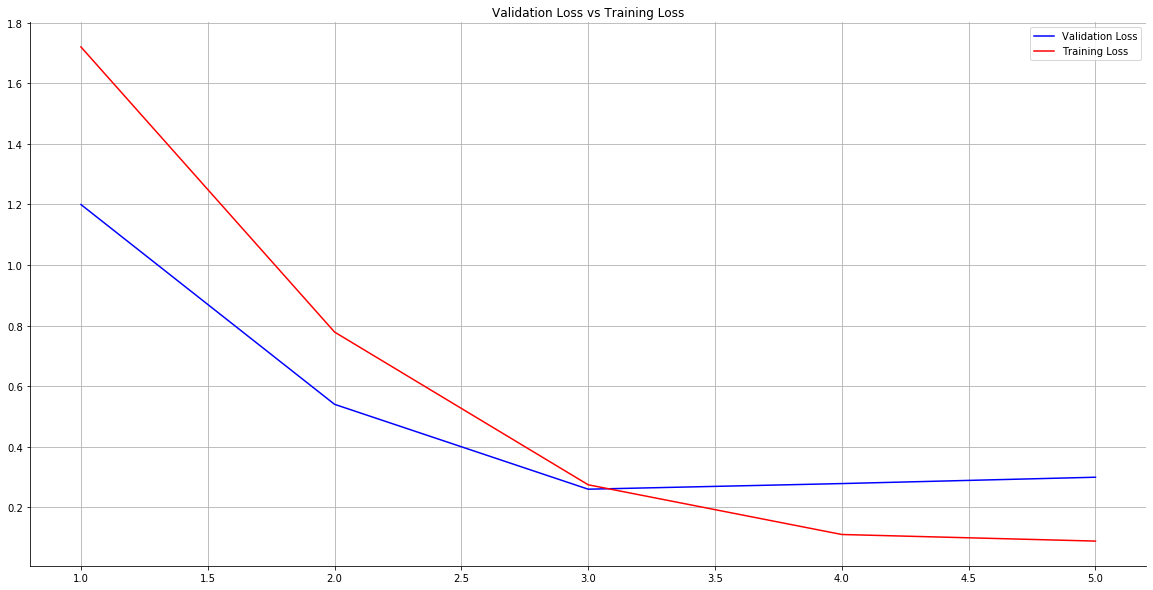

In [0]:
val_loss = result.history['val_loss']
train_loss = result.history['loss']
x = list(np.arange(1,6))
plt.figure(figsize = (20,10))
plt.grid()
sns.lineplot(x=x,y = val_loss,color = 'blue',label = 'Validation Loss')
sns.lineplot(x=x,y=train_loss,color = 'red',label = 'Training Loss')
plt.legend()
plt.title("Validation Loss vs Training Loss")
sns.despine()

## Earlier the model was overfitting so we try different method like dropout, batchnormalization but most effective was adding L1 and L2 regularizer.  

# Weights Distribution Of Different Layers

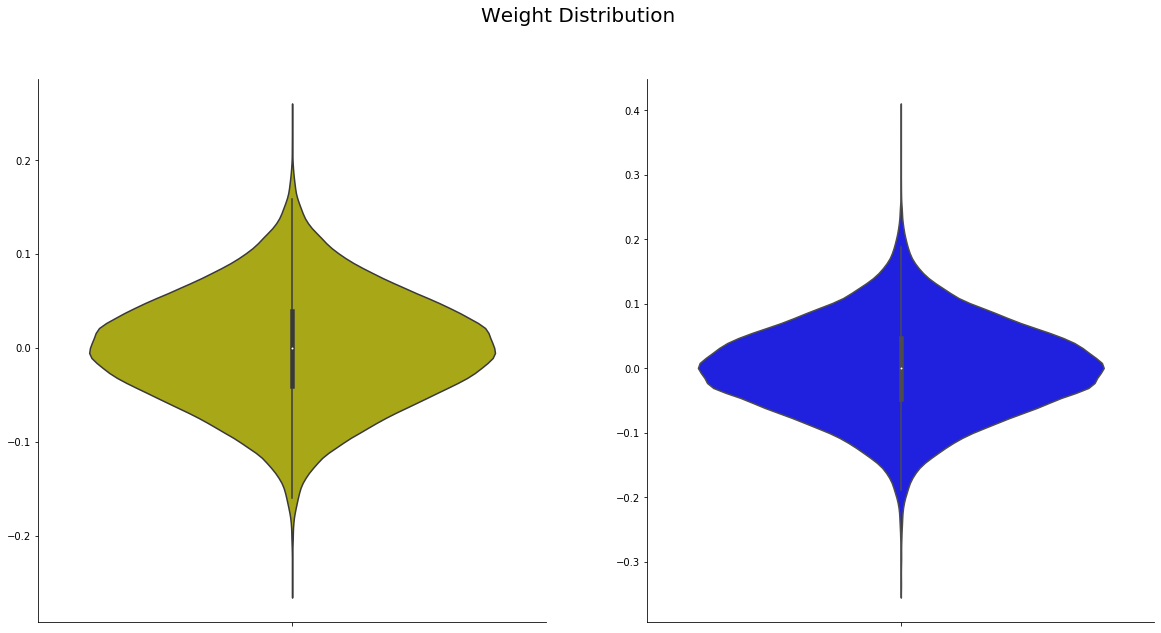

In [0]:
embed_wgt  = model_lstm_1.get_weights()[0]
lstm_wgt = model_lstm_1.get_weights()[6]
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
sns.violinplot(y= embed_wgt,color = 'y',label = "Embedded layers weights")
plt.subplot(1,2,2)
sns.violinplot(y = lstm_wgt,color = 'blue',label = "LSTM layers weights")
plt.suptitle("Weight Distribution", fontsize = 20)
sns.despine()

## Model with 2 LSTM Layers

In [26]:
from keras.layers import BatchNormalization,Activation
from keras.regularizers import L1L2
reg = L1L2(0.01,0.01)
embed_layer = 32
model_lstm_2 = Sequential()
model_lstm_2.add(Embedding(5000,embed_layer,input_length=max_seq))
model_lstm_2.add(BatchNormalization())
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(LSTM(100,bias_regularizer=reg,return_sequences=True))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(LSTM(50,bias_regularizer=reg))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Dense(1,activation='sigmoid'))
model_lstm_2.summary()

W0828 02:06:07.321551 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 02:06:07.367465 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 02:06:07.375101 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 02:06:07.488608 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 02:06:07.512006 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
__________

In [27]:
model_lstm_2.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
result_2 = model_lstm_2.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.2)
score_2 = model_lstm_2.evaluate(X_test,y_test,verbose=0)


W0828 02:06:13.582489 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 02:06:13.607541 139999701084032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 02:06:13.613219 139999701084032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 564s 20ms/step - loss: 2.4393 - acc: 0.8881 - val_loss: 1.6585 - val_acc: 0.9031
Epoch 2/5
28000/28000 [==============================] - 570s 20ms/step - loss: 1.0814 - acc: 0.9302 - val_loss: 0.7048 - val_acc: 0.9074
Epoch 3/5
28000/28000 [==============================] - 566s 20ms/step - loss: 0.3321 - acc: 0.9480 - val_loss: 0.2630 - val_acc: 0.9091
Epoch 4/5
28000/28000 [==============================] - 566s 20ms/step - loss: 0.1115 - acc: 0.9587 - val_loss: 0.2718 - val_acc: 0.9053
Epoch 5/5
28000/28000 [==============================] - 567s 20ms/step - loss: 0.0974 - acc: 0.9644 - val_loss: 0.3130 - val_acc: 0.9063


NameError: ignored

In [28]:
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Test loss: 0.2951615286697944
Test accuracy: 0.9150666666666667


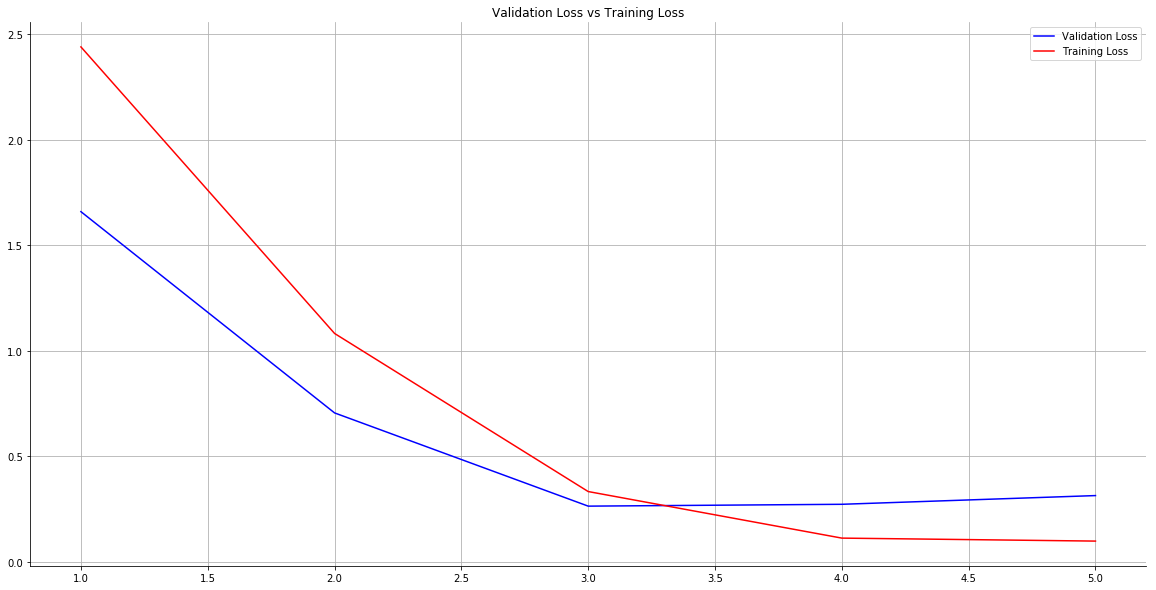

In [29]:
val_loss = result_2.history['val_loss']
train_loss = result_2.history['loss']
x = list(np.arange(1,6))
plt.figure(figsize = (20,10))
plt.grid()
sns.lineplot(x=x,y = val_loss,color = 'blue',label = 'Validation Loss')
sns.lineplot(x=x,y=train_loss,color = 'red',label = 'Training Loss')
plt.legend()
plt.title("Validation Loss vs Training Loss")
sns.despine()

In [35]:
len(model_lstm_2.get_weights()[9])

50

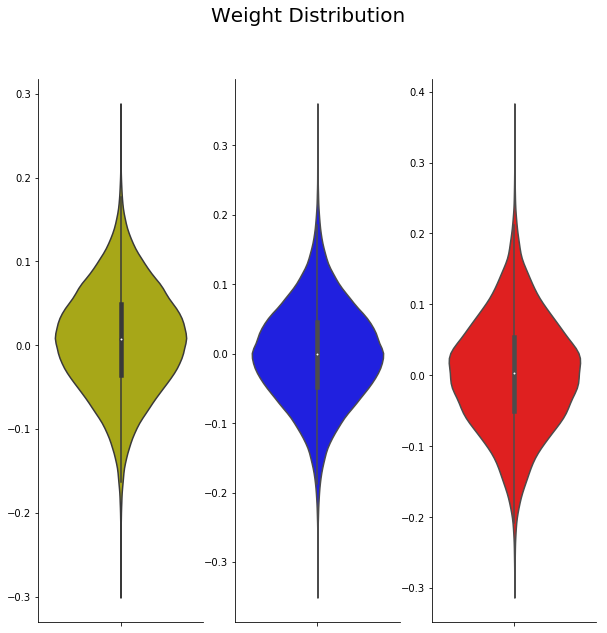

In [37]:
embed_wgt  = model_lstm_2.get_weights()[0]
lstm_wgt_1 = model_lstm_2.get_weights()[6]
lstm_wgt_2 = model_lstm_2.get_weights()[9]
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
sns.violinplot(y= embed_wgt,color = 'y',label = "Embedded layers weights")
plt.subplot(1,3,2)
sns.violinplot(y = lstm_wgt_1,color = 'blue',label = "LSTM layers weights")
plt.subplot(1,3,3)
sns.violinplot(y = lstm_wgt_2,color = 'red',label = "LSTM layers weights")
plt.suptitle("Weight Distribution", fontsize = 20)
sns.despine()